In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import glob, os
import my_lib as mylib
import pprint
pp = pprint.PrettyPrinter(indent=4)

#Basic Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer

import seaborn as sns
sns.set_style("darkgrid")

from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)  

SEED = 42
target = "TARGET"

In [53]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
df = pd.read_csv(f"data/df_train_sample_00_of_20.csv", dtype=str)
display(df.head(2))
display(df.shape)

,RECORD_ID,DISCHARGE,THCIC_ID,PROVIDER_NAME,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_STATE,PAT_COUNTRY,COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,FIRST_PAYMENT_SRC,TYPE_OF_BILL,TOTAL_CHARGES,TOTAL_NON_COV_CHARGES,TOTAL_CHARGES_ACCOMM,TOTAL_NON_COV_CHARGES_ACCOMM,TOTAL_CHARGES_ANCIL,TOTAL_NON_COV_CHARGES_ANCIL,POA_PROVIDER_INDICATOR,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,OTH_DIAG_CODE_1,MS_MDC,MS_DRG,MS_GROUPER_VERSION_NBR,MS_GROUPER_ERROR_CODE,APR_MDC,APR_DRG,RISK_MORTALITY,ILLNESS_SEVERITY,APR_GROUPER_VERSION_NBR,APR_GROUPER_ERROR_CODE,ATTENDING_PHYSICIAN_UNIF_ID,ENCOUNTER_INDICATOR,CERT_STATUS,TARGET
0,320136748870,2013Q3,838400,Memorial Hermann Rehab Hospital Katy,3,4,TX,US,201,06,07,4,2,2,1,20,MA,111,1671.00,0.00,1145.00,0.00,526.00,0.00,X,V5789,V5789,1919,23,945,01300,00,23,860,2,3,07300,00,1229763162,01,1,short
1,120130546450,2013Q1,409000,John Peter Smith Hospital,1,1,TX,US,367,03,01,5,1,2,2,13,MA,111,53064.01,0.00,4092.00,0.00,48972.01,0.00,M,78650,41401,42822,05,247,01300,00,05,175,2,2,07300,00,1578252829,01,2,short


(49984, 42)

#### TYPE_OF_ADMISSION

**Distribution**

1    21625
3    12951
2     8564
4     6409
5      233
9      201
`        1
Name: TYPE_OF_ADMISSION, dtype: int64

**Count Plots**

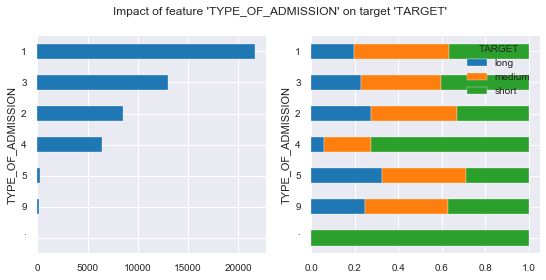

**Chi-Sq Goodness of Fit**

Chi-Square statistic 3.3733e+03 (p=0.0000e+00, dof=12)


In [7]:
f = "TYPE_OF_ADMISSION"
mylib.eda_categorical(df, f, target, max_categories=20, labels=None, header=True, brief=False)

### Convert Tager Categrories into codes or numbers

In [8]:
from sklearn.preprocessing import LabelEncoder

if df.TARGET.dtype != int:
    print("Encoding Taget....")
    le = LabelEncoder()
    df["TARGET"] = le.fit_transform(df.TARGET)
    print("DONE")
else:
    pass

Encoding Taget....
DONE


## Test-Train-Split

In [12]:
x = df.drop(target, axis=1)
y = df.TARGET

df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(x,y, test_size = 0.4, stratify = y, random_state = SEED)

## Encoding of Categorical Features

In [13]:
features = ["TYPE_OF_ADMISSION"]#,"PAT_STATE", "SEX_CODE", "RACE", "ETHNICITY", "ADMIT_WEEKDAY"]

dfx_train_model = df_x_train.loc[:,[]]
dfx_test_model = df_x_test.loc[:,[]]

for feature in features:
    lb = LabelBinarizer()
    
    lb_result = lb.fit_transform(df_x_train[feature].astype("str"))
    names = [f'{feature}_{l}' for l in lb.classes_]
    for k, name in enumerate(names):
        dfx_train_model[name] = lb_result[:,k]
    
    lb_result = lb.transform(df_x_test[feature].astype("str"))
    names = [f'{feature}_{l}' for l in lb.classes_]
    for k, name in enumerate(names):
        dfx_test_model[name] = lb_result[:,k]

In [14]:
print(pp.pprint(list(enumerate(names))))

[   (0, 'TYPE_OF_ADMISSION_1'),
    (1, 'TYPE_OF_ADMISSION_2'),
    (2, 'TYPE_OF_ADMISSION_3'),
    (3, 'TYPE_OF_ADMISSION_4'),
    (4, 'TYPE_OF_ADMISSION_5'),
    (5, 'TYPE_OF_ADMISSION_9')]
None


In [15]:
pp.pprint(names)

[   'TYPE_OF_ADMISSION_1',
    'TYPE_OF_ADMISSION_2',
    'TYPE_OF_ADMISSION_3',
    'TYPE_OF_ADMISSION_4',
    'TYPE_OF_ADMISSION_5',
    'TYPE_OF_ADMISSION_9']


In [16]:
lb.classes_

array(['1', '2', '3', '4', '5', '9'], dtype='<U1')

In [17]:
dfx_train_model.head()

,TYPE_OF_ADMISSION_1,TYPE_OF_ADMISSION_2,TYPE_OF_ADMISSION_3,TYPE_OF_ADMISSION_4,TYPE_OF_ADMISSION_5,TYPE_OF_ADMISSION_9
44930,0,0,1,0,0,0
14686,0,0,0,1,0,0
44674,0,0,1,0,0,0
504,0,0,1,0,0,0
7052,1,0,0,0,0,0


In [25]:
x_train, y_train = dfx_train_model.values, df_y_train.values
x_test, y_test = dfx_test_model.values, df_y_test.values

In [27]:
# Using a few classifiers with the dataset
classifiers = {
    "LogisiticRegression":LogisticRegression(),
    "KNearest":KNeighborsClassifier(),
    "SupportVectorClassifier":SVC(),
    "Decision Tree Classifier":DecisionTreeClassifier()
}